<a href="https://colab.research.google.com/github/Gooogr/Kaggle_Global_Wheat_Detection/blob/master/GWD_YOLO_v4_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gc #garbage collector
import ast # operate with string representation of list
import os
import fnmatch
import re

import pandas as pd
import numpy as np
import cv2

from google.colab import files
from google.colab.patches import cv2_imshow

In [2]:
# Enable GPU
# Check what we get: K80, P100, K4 or T4.
! nvidia-smi

Sat Jul 18 15:05:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# add kaggle.json key
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gooogr","key":"f9f3caa700a46c4bdc5f3840e5658934"}'}

## Dataset downloading

In [4]:
 ! mkdir ~/.kaggle #inroot folder 
 ! cp kaggle.json ~/.kaggle/
 ! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle -v # reinstall kaggle API to fix bugs with data downloading

Kaggle API 1.5.4


In [6]:
! pip uninstall -y kaggle
! pip install --upgrade pip
! pip install -q kaggle==1.5.6
! kaggle -v

Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
     |████████████████████████████████| 1.5MB 2.8MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 58 kB 1.6 MB/s 
Kaggle API 1.5.6


In [7]:
! kaggle competitions download -c global-wheat-detection
! unzip -q global-wheat-detection.zip

 99% 601M/607M [00:17<00:00, 48.1MB/s]
100% 607M/607M [00:17<00:00, 36.6MB/s]


### Utilities

In [8]:
def create_yolo_bbox(x):
    x, y, width, height = list(map(int, ast.literal_eval(x)))
    x_c = (x + width // 2) / 1024
    y_c = (y + height // 2) / 1024
    return ([x_c, y_c, (width / 1024), (height / 1024)])

def write_yolo_txt(save_dir):
    unique_ids = train_df['image_id'].unique()
    for img_id in unique_ids:
        df_sample = train_df[train_df['image_id'] == img_id]
        temp_ser = df_sample['yolo_bbox']

        file = open(os.path.join(save_dir, (img_id + ".txt")), "w")
        for bbox in temp_ser:
            row = ' '.join(str(item) for item in bbox)
            file. write('0 ') #class number
            file.write(row)
            file.write('\n')
        file.close()

def show_data_sample(dir_path):
  '''
  Show random sample from dataset with boundary box
  '''
  txt_files = []
  img_files = []
  for txt_file in os.listdir(dir_path):
      if fnmatch.fnmatch(txt_file, '*.txt'):
        txt_files.append(txt_file)
  print('Data pairs amount:', len(txt_files))

  sample_name = txt_files[np.random.randint(len(txt_files))].split('.')[0]

  txt_sample = open(os.path.join(dir_path, sample_name + '.txt'), 'r')
  img_sample = cv2.imread(os.path.join(dir_path, sample_name + '.jpg'))
  height = img_sample.shape[0]
  width = img_sample.shape[1]
  for line in txt_sample.readlines():
      #print(re.split('\s',line)[0:5])
      yolo_bndbox = (list(map(float, re.split('\s',line)[0:5])))
      voc_bndbox = yolo2voc(yolo_bndbox, width, height)
      img_sample = cv2.rectangle(img_sample, voc_bndbox[:2], voc_bndbox[2:], color=[255, 0, 0], thickness=2)
  img_sample = cv2.resize(img_sample, (0,0), fx=0.5, fy=0.5)  
  cv2_imshow(img_sample)


def yolo2voc(data, w, h):
  '''
  Convert boundary box from YOLO format to VOC
  '''
  bbox_width = float(data[3]) * w
  bbox_height = float(data[4]) * h
  center_x = float(data[1]) * w
  center_y = float(data[2]) * h
  x_min = int(center_x - (bbox_width / 2))
  y_min = int(center_y - (bbox_height / 2))
  x_max = int(center_x + (bbox_width / 2))
  y_max = int(center_y + (bbox_height / 2))
  return(x_min, y_min, x_max, y_max)

### Constants

In [9]:
MAIN_PATH = '/content/'
TRAIN_DIR_PATH = '/content/train'
TEST_DIR_PATH = '/content/test'

## Create txt YOLO boxes files

Create txt files for images with bboxes

In [10]:
train_df = pd.read_csv(os.path.join(MAIN_PATH, 'train.csv'))
train_df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [11]:
%%time
train_df['yolo_bbox'] = train_df['bbox'].apply(lambda x: create_yolo_bbox(x))

CPU times: user 2.15 s, sys: 23.2 ms, total: 2.17 s
Wall time: 2.17 s


In [12]:
%%time
write_yolo_txt(TRAIN_DIR_PATH)

CPU times: user 27 s, sys: 256 ms, total: 27.3 s
Wall time: 27.3 s


In [13]:
# # Uncomment to see txt example
# ! cat ./train/344bdc291.txt

Create txt files for images without bboxes

In [14]:
all_img_ids = set([item[:-4] for item in  os.listdir(TRAIN_DIR_PATH) if '.jpg' in item])
bboxes_img_ids = set(train_df['image_id'].unique().tolist())
no_bboxes_img_ids = all_img_ids - bboxes_img_ids

In [16]:
def write_empty_yolo_txt(save_dir, img_ids):
    for img_id in img_ids:
        file = open(os.path.join(save_dir, (img_id + ".txt")), "w")
        file.close()

In [17]:
write_empty_yolo_txt(TRAIN_DIR_PATH, no_bboxes_img_ids)

Data pairs amount: 3422


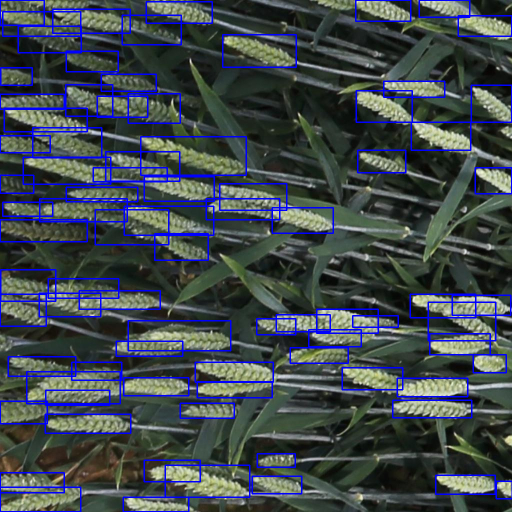

In [18]:
# Check correctness of converted bboxes
show_data_sample(TRAIN_DIR_PATH)

## Setting up YOLO Darknet

In [19]:
def make_darknet():
  '''
  Run this function if darknet wasn`t setted up your root project folder
  '''
  # Clone and  make darknet in My Drive folder. We should prepare all config files there befory copy them to tmp
  ! git clone https://github.com/AlexeyAB/darknet.git

  # Enable GPU learning
  %cd darknet
  !sed -i 's/OPENCV=0/OPENCV=1/' Makefile
  !sed -i 's/GPU=0/GPU=1/' Makefile
  !sed -i 's/CUDNN=0/CUDNN=1/' Makefile
  !sed -i 's/OPENMP=0/OPENMP=1/' Makefile

  # verify CUDA
  !/usr/local/cuda/bin/nvcc --version

  ! make --silent

Check saving rules in ```/content/darknet/src/detector.c```, lines 384 - 403

```
 if (iteration >= (iter_save + 1000) || iteration % 1000 == 0) {
     sprintf(buff, "%s/%s_%d.weights", backup_directory, base, iteration);
 if (iteration >= (iter_save_last + 100) || (iteration % 100 == 0 && iteration > 1)) {
     sprintf(buff, "%s/%s_last.weights", backup_directory, base);
```
Change it if you need, but don't forget to ```! make``` it arter that.



In [20]:
%%capture
# Uncomment to make absense darknet from scratch 
make_darknet()

In [21]:
! pwd

/content/darknet


In [22]:
def download_pretrained_data():
  # YOLOv4
  ! wget --quiet https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights
  ! wget --quiet https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137
  

In [23]:
download_pretrained_data()

In [24]:
def predict_sample():
  ! chmod 777 ./darknet
  ! ./darknet detector test cfg/coco.data cfg/yolov4.cfg yolov4.weights data/horses.jpg 
  image = cv2.imread('predictions.jpg')
  cv2_imshow(image)

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 8, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   3 route  1 		                           ->  304 x 304 x  64 
   4 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   5 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   6 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 304 x 304 x  64 0.006 BF
   8 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 

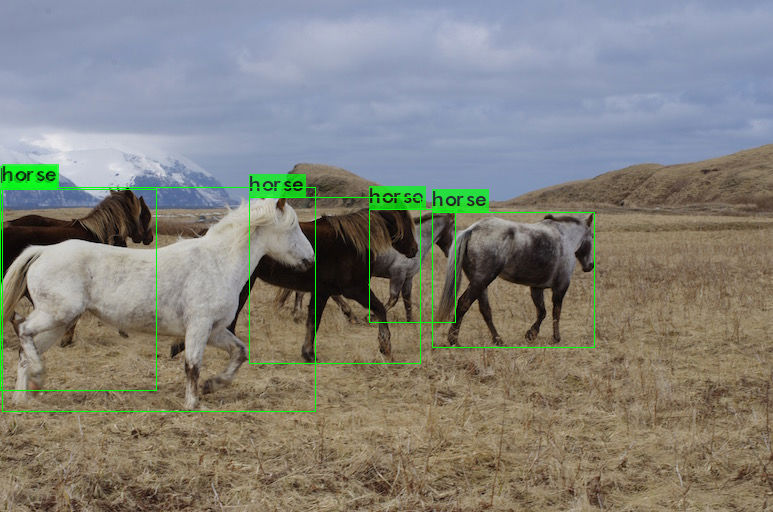

In [25]:
# check that we get working YOLO version
predict_sample()

### Prepare config files

In [26]:
% cd /content/
! wget --quiet https://raw.githubusercontent.com/Gooogr/YOLO_Toolkit/master/splitTrainAndTest.py

/content


In [27]:
# Create train and test(validate) txt files. Split ratio will be 0.1
! python3 splitTrainAndTest.py /content/train

In [28]:
! mkdir /content/yolo_config_files
% cd /content/yolo_config_files

/content/yolo_config_files


> obj.names

One class - one line. If you make a mistake in the order of the labels, the algorithm will work, but will incorrectly name the detected objects.

In [29]:
%%writefile obj.names
Wheat head

Writing obj.names


> yolo.data

Specify classes amount. Check pathes to other files:<br>
classses = *amount of your classes*<br>
valid  = /content/test.txt<br>
names = /content/yolo_config_files/obj.names<br>
backup = /content/yolo_weights<br>
train  = /content/train.txt<br>

In [30]:
% cd /content/yolo_config_files

/content/yolo_config_files


In [31]:
%%writefile yolo.data
classses = 1
valid = /content/test.txt
names = /content/yolo_config_files/obj.names
backup = /content/yolo_weights
train = /content/train.txt

Writing yolo.data


> yolov4.cfg

How to configure cfg file<br>
https://github.com/AlexeyAB/darknet#how-to-train-to-detect-your-custom-objects

In [32]:
# #Generate anchors for cfg file
# # Can't open labels because of 49 files without bboxes
# % cd /content/darknet
# ! chmod 777 ./darknet
# ! ./darknet detector calc_anchors \
# /content/yolo_config_files/yolo.data -num_of_clusters 1 -width 608 -height 608 -show
# # Result - 50, 46

In [33]:
% cd /content/yolo_config_files/
! wget --quiet https://raw.githubusercontent.com/Gooogr/Kaggle_Global_Wheat_Detection/master/yolov4-custom.cfg \
-O /content/yolo_config_files/yolov4.cfg

/content/yolo_config_files


In [34]:
# Create empty directiry for saving weights during the training
! mkdir /content/yolo_weights

In [35]:
# Safety measure to prevent yolo training start after massive pushing Shift + Enter
assert False

AssertionError: ignored

### Train YOLOv4

#### Train from scratch

In [36]:
def train_yolo_from_scratch():
    # Train YOLO
    % cd /content/darknet
    ! ./darknet detector train \
    /content/yolo_config_files/yolo.data \
    /content/yolo_config_files/yolov4.cfg \
    ./yolov4.conv.137 > /content/temp_train.log -dont_show  

In [37]:
# train_yolo_from_scratch()

#### Continue training

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [42]:
# select file from google disk or use curl/wget if you store it somewhere else 
% cp /content/drive/'My Drive'/colab_notebooks/Kaggle_Global_Wheat_Detection/yolov4_1300.weights /content/yolo_weights
! mv /content/yolo_weights/yolov4_1300.weights /content/yolo_weights/yolov4_last.weights

In [40]:
def continue_yolo_training():
    # Continue YOLO training
    % cd /content/darknet
    ! ./darknet detector train \
    /content/yolo_config_files/yolo.data \
    /content/yolo_config_files/yolov4.cfg \
    /content/yolo_weights/yolov4_last.weights > /content/temp_train.log -dont_show  


In [ ]:
# continue_yolo_training()
